In [14]:
# Specify relative paths
from pathlib import Path

BASE_DIR = Path.cwd()
data_path = BASE_DIR / "data" / "statcast_switch_split.csv"

In [15]:
# Import the required libraries and read in data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

rawdata = pd.read_csv(data_path, encoding="utf-8")
print(rawdata.head())

  pitch_type   game_date  release_speed  release_pos_x  release_pos_z  \
0         FF  2024-04-02           95.0          -2.01           5.22   
1         CH  2024-04-02           88.5          -2.09           4.95   
2         SI  2024-04-02           95.0          -2.02           5.12   
3         KC  2024-04-02           80.8          -3.13           5.61   
4         FF  2024-04-02           95.4          -1.95           5.12   

         player_name  batter  pitcher     events    description  ...  \
0  Rocchio, Brayan-L  677587   622491     single  hit_into_play  ...   
1  Rocchio, Brayan-L  677587   622491        NaN           foul  ...   
2  Rocchio, Brayan-L  677587   622491        NaN  called_strike  ...   
3     Rizzo, Anthony  519203   668678  field_out  hit_into_play  ...   
4     Hedges, Austin  595978   622491  strikeout       foul_tip  ...   

   n_thruorder_pitcher  n_priorpa_thisgame_player_at_bat  \
0                    3                                 2   
1       

In [16]:
# Make a copy of the raw data and select relevant columns
data = rawdata.copy()
data = data[['player_name', 'launch_angle', 'launch_speed']]
data = data.dropna()

# Calculate the number of records for each player
player_counts = data.groupby('player_name').size()

# Extract player names with 30 or more records
players_with_30_or_more = player_counts[player_counts >= 30].index

# Filter the data to include only players with 30 or more records
data = data[data['player_name'].isin(players_with_30_or_more)]

# Create a list of unique player names
batter_list = list(data['player_name'].unique())

# Compute the mean launch angle and speed grouped by player
attack_angle = data.groupby('player_name').mean().reset_index()

Attack angle based on parabola fitting: 5.73°
Attack angle based on top 15 BBE average: 10.47°
Final attack angle: 8.10°


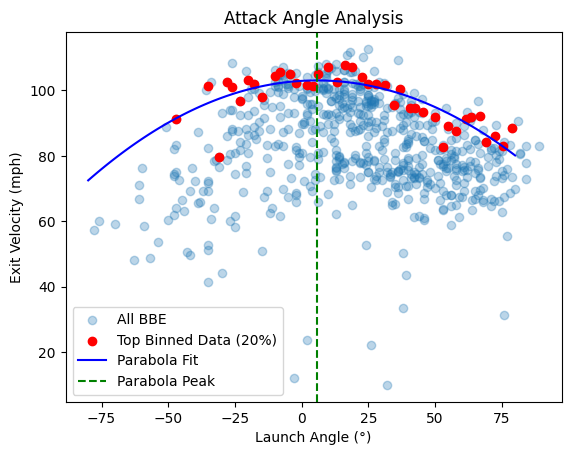

In [17]:
#************************Example************************
# Select data for a specific batter
batter = data[data['player_name'] == batter_list[11]].copy()

# Group data by angle bins and extract the top 20%
bin_size = 3
batter['AngleBin'] = (batter['launch_angle'] // bin_size) * bin_size
top_percent = 0.2

# Filter the top 20% of data within each angle bin
top_bbe = (
    batter.groupby('AngleBin')
    .apply(lambda g: g.nlargest(int(len(g) * top_percent), 'launch_speed'))
    .reset_index(drop=True)
)

# Define the parabolic fitting function
def parabola(x, a, b, c):
    return a * x**2 + b * x + c

# Extract data for fitting
red_points = top_bbe.groupby('AngleBin')[['launch_angle', 'launch_speed']].mean().reset_index()
x_data, y_data = red_points['launch_angle'], red_points['launch_speed']

# Perform curve fitting
try:
    params, _ = curve_fit(parabola, x_data, y_data)
    a, b, c = params
    attack_angle_parabola = -b / (2 * a)
except RuntimeError:
    print("Curve fitting failed. Check your data distribution.")
    attack_angle_parabola = np.nan

# Calculate the average launch angle of the top 15 BBE
top_15_bbe = batter.nlargest(15, 'launch_speed')
attack_angle_average = top_15_bbe['launch_angle'].mean()

# Compute the final attack angle
if not np.isnan(attack_angle_parabola):
    final_attack_angle = (attack_angle_parabola + attack_angle_average) / 2
else:
    final_attack_angle = attack_angle_average

# Print results
print(f"Attack angle based on parabola fitting: {attack_angle_parabola:.2f}°" if not np.isnan(attack_angle_parabola) else "Parabola fitting failed")
print(f"Attack angle based on top 15 BBE average: {attack_angle_average:.2f}°")
print(f"Final attack angle: {final_attack_angle:.2f}°")

# Visualize the data
plt.scatter(batter['launch_angle'], batter['launch_speed'], alpha=0.3, label='All BBE')
plt.scatter(x_data, y_data, color='red', label='Top Binned Data (20%)')
if not np.isnan(attack_angle_parabola):
    plt.plot(
        np.linspace(-80, 80, 100),
        parabola(np.linspace(-80, 80, 100), *params),
        color='blue',
        label='Parabola Fit'
    )
    plt.axvline(attack_angle_parabola, color='green', linestyle='--', label='Parabola Peak')
plt.xlabel('Launch Angle (°)')
plt.ylabel('Exit Velocity (mph)')
plt.legend()
plt.title('Attack Angle Analysis')
plt.show()

In [18]:
# Define a parabolic fitting function
def parabola(x, a, b, c):
    return a * x**2 + b * x + c

def calculate_attack_angle(row):
    # Select data for the specific batter
    batter = data[data['player_name'] == row['player_name']].copy()

    # Group data by angle bins and extract the top 20%
    bin_size = 3
    batter['AngleBin'] = (batter['launch_angle'] // bin_size) * bin_size
    top_percent = 0.2

    # Filter the top 20% of data within each angle bin
    top_bbe = (
        batter.groupby('AngleBin', group_keys=False)
        .apply(lambda g: g.nlargest(max(1, int(len(g) * top_percent)), 'launch_speed'))
        .reset_index(drop=True)
    )

    # Extract data for fitting
    red_points = top_bbe.groupby('AngleBin')[['launch_angle', 'launch_speed']].mean().reset_index()
    x_data, y_data = red_points['launch_angle'], red_points['launch_speed']

    # Check data validity
    if len(x_data) < 3:
        print(f"Insufficient data for player: {row['player_name']}")
        return np.nan

    # Perform curve fitting
    try:
        params, _ = curve_fit(parabola, x_data, y_data)
        a, b, c = params
        attack_angle_parabola = -b / (2 * a)
    except RuntimeError:
        print(f"Curve fitting failed for player: {row['player_name']}")
        attack_angle_parabola = np.nan

    # Calculate the average launch angle of the top 15 BBE
    top_15_bbe = batter.nlargest(15, 'launch_speed')
    attack_angle_average = top_15_bbe['launch_angle'].mean()

    # Compute the final attack angle
    if not np.isnan(attack_angle_parabola):
        final_attack_angle = (attack_angle_parabola + attack_angle_average) / 2
    else:
        final_attack_angle = attack_angle_average

    return final_attack_angle

# Apply the function row-wise
attack_angle['attack_angle'] = attack_angle.apply(calculate_attack_angle, axis=1)
attack_angle = attack_angle[['player_name', 'attack_angle']]
print(attack_angle.head())

         player_name  attack_angle
0         Abrams, CJ     15.378242
1        Abreu, José      5.253244
2      Abreu, Wilyer     17.837165
3  Acuña Jr., Ronald     13.396897
4   Acuña, Luisangel      4.588206


In [19]:
output_path = BASE_DIR / "data" / "attack_angle.csv"

attack_angle.to_csv(output_path, index=False)